# SDG 11.2.1 

## 11.2.1
Proportion of population that has convenient access to public transport, by sex, age and persons with disabilities 

**11.2.1 is under 11.2**

## 11.2
By 2030, provide access to safe, affordable, accessible and sustainable transport systems for all, improving road safety, notably by expanding public transport, with special attention to the needs of those in vulnerable situations, women, children, persons with disabilities and older persons 


Method
<ol>
1) get public transport location data - NAPTAN a) Clean it if necessary
2) get population location data -  LSOA from ONS
3) use Fiona to read location data
4) limit to one or two locations, e.g. London and a more rural area
5) draw Euclidean Buffers around LSOA polygon centre points
6) find number of public transport stops in the polygon with “points in polygons” approach
</ol>

In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt 
from shapely.geometry import Point, Polygon

In [11]:
## I have downloaded the data locally
## Location of the data is : http://naptan.app.dft.gov.uk/datarequest/GTFS.ashx
datapath = r'/home/james/Documents/SDG_11.2.1/data'

In [12]:
## Extracted the Stops.txt file. 
## Making into a Pandas dataframe

stops_df = pd.read_csv(os.path.join(datapath,'Stops.txt'), delimiter='\t')
stops_df.sample(15)


,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type
371406,66806710009,26523265,"Alva, Dickies Wells (opp)",56.15250,-3.78890,NaN,3.0
280273,450025847,45025847,"Leeds City Centre, Whitehall Road (stop S16)",53.79418,-1.55732,NaN,3.0
225991,390010536,sufagmwj,"Wherstead, The Street (adj)",52.02264,1.13838,NaN,3.0
86220,1600GLC078,glogjmwd,"Lechlade, Keble Close (NE-bound)",51.70092,-1.68868,NaN,3.0
134484,2400105961,kntjtjdg,"Hawkenbury, The Hawkenbury (adj)",51.17629,0.58101,NaN,3.0
46821,1000DLMS1401,dbsdtjpt,"Linton, Red Lion (Adj)",52.74744,-1.59466,NaN,3.0
129806,227000010750,scugdgj,"Scunthorpe, Sorrell Way (adj)",53.60391,-0.67884,NaN,3.0
7263,021013259,ahladgaj,"Dunstable, Eastern Avenue (adj)",51.88725,-0.50782,NaN,3.0
346814,61501953,75258637,"Garrion Bridge, Cornsilloch Brae (after)",55.74009,-3.93043,NaN,3.0
221881,3800C615401,stadwtwg,"Featherstone, Whitehouse Farm (opp)",52.64822,-2.09463,NaN,3.0


In [13]:

def make_geo_df(df,col_x, col_y):
    """A function to create a geodataframe from a datafrom. Supply the dataframe, and the names of lon and lat columns."""
    crs = {'init': 'epsg:4326'} #"EPSG:4326" "EPSG:27700"
    geometry = [Point(xy) for xy in zip(df[col_x], df[col_y])]
    geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    return geo_df

In [14]:
## Creating the GeoDataframe version of stops_df
stops_geo_df = make_geo_df(stops_df,'stop_lon','stop_lat')

## Deleting stops_df to free up memory
del stops_df

In [15]:
## Checking the coordinate reference system of stops_geo_df
## 227700 is expected
stops_geo_df.crs

{'init': 'epsg:4326'}

In [16]:
## Getting a sample of the new geo_df

stops_geo_df.sample(10)

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type,geometry
118516,2000G500845,wocdgtat,"Fairfield, Fairfield Place (opp)",52.08394,-1.95032,NaN,3.0,POINT (-1.95032 52.08394)
89362,1600GL2717,gloamdwa,"Kilcot, Garage (W-bound)",51.92677,-2.44462,NaN,3.0,POINT (-2.44462 51.92677)
244208,410000061239,twrjapam,"Meadow Well, Minton Lane (SE-Bound)",55.00264,-1.45989,NaN,3.0,POINT (-1.45989 55.00264)
191806,3300BA0415,ntsdtgtg,"Harworth, Baulk Lane (S-bound)",53.42024,-1.07454,NaN,3.0,POINT (-1.07454 53.42024)
269865,450013292,45013292,"Aberford, Main Street St Johns Close",53.83655,-1.34241,NaN,3.0,POINT (-1.34241 53.83655)
342398,60903132,45243753,"Govan, Drumoyne pr School (before)",55.85574,-4.33422,NaN,3.0,POINT (-4.33422 55.85574)
211533,370021039,37021039,"Fir Vale, Owler Lane (opp)",53.40816,-1.45056,NaN,3.0,POINT (-1.45056 53.40816)
365363,6490IM482,26423948,"Cortachy, Carroch Road End (at)",56.70994,-3.04142,NaN,3.0,POINT (-3.04142 56.70994)
61261,1200DOB20691,doradmtd,"Bothenhampton, Coopers Drive (E-bound)",50.72229,-2.75311,NaN,3.0,POINT (-2.75311 50.72229)
5638,0190NSC31051,wsmjajd,"Redhill, Ashford Road (NE-bound)",51.37211,-2.71183,NaN,3.0,POINT (-2.71183 51.37211)


In [17]:
## Some stops in London contain the code 49001, will use that to filter for the moment
some_stops_in_LND = stops_geo_df[stops_geo_df.stop_id.str.contains('49001')].sample(10)


In [19]:
# Building the map of Local Authority Districts

map_data_path = r'/home/james/Documents/SDG_11.2.1/data/Local Authority Districts (December 2017) Generalised Clipped Boundaries in United Kingdom (WGS84)'
locAuth_map_df = gpd.read_file(os.path.join(map_data_path,'Local_Authority_Districts_December_2017_Generalised_Clipped_Boundaries_in_United_Kingdom_WGS84.shp'))

### I have also downloaded the output area for London, but am struggling with the CRS
# OA_2011_London_gen_MHW.shp'

In [23]:
## Testing that I can filter based on placename, e.g. Islington
locAuth_map_df[locAuth_map_df['lad17nm']=='Islington']
## works!

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
186,312,E09000019,Islington,None,531158,184647,-0.10992,51.5455,0.001923,0.235052,"POLYGON ((-0.11920 51.57465, -0.11879 51.57433..."


In [24]:
# likewise, I can filter on the lad17cd code. I will use the code to filter for places in London
## I was told 'E09' is for London
locAuth_map_df[locAuth_map_df.lad17cd.str.contains('E09')]

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
53,298,E09000005,Brent,None,519615,186468,-0.275680,51.5644,0.005603,0.456380,"POLYGON ((-0.26875 51.60087, -0.26136 51.59467..."
98,318,E09000025,Newham,None,540721,183327,0.027369,51.5313,0.004689,0.402297,"POLYGON ((0.05408 51.55984, 0.05471 51.55909, ..."
101,319,E09000026,Redbridge,None,543512,189478,0.070085,51.5859,0.007315,0.550043,"POLYGON ((0.03113 51.62274, 0.03582 51.61882, ..."
103,325,E09000032,Wandsworth,None,525152,174137,-0.200210,51.4524,0.004431,0.456191,"POLYGON ((-0.12797 51.48498, -0.12910 51.48254..."
106,310,E09000017,Hillingdon,None,508166,183120,-0.441820,51.5366,0.014998,0.717381,"POLYGON ((-0.49574 51.63154, -0.49514 51.63105..."
122,326,E09000033,Westminster,None,528268,180871,-0.152950,51.5122,0.002779,0.310957,"POLYGON ((-0.17574 51.53871, -0.17511 51.53814..."
176,311,E09000018,Hounslow,None,512744,174965,-0.378440,51.4624,0.007241,0.720192,"MULTIPOLYGON (((-0.28237 51.50336, -0.27948 51..."
186,312,E09000019,Islington,None,531158,184647,-0.109920,51.5455,0.001923,0.235052,"POLYGON ((-0.11920 51.57465, -0.11879 51.57433..."
188,313,E09000020,Kensington and Chelsea,None,525757,179053,-0.189760,51.4964,0.001572,0.241396,"POLYGON ((-0.22918 51.53066, -0.22928 51.53042..."
195,314,E09000021,Kingston upon Thames,None,519508,167389,-0.283670,51.3930,0.004814,0.404645,"POLYGON ((-0.25271 51.42283, -0.25123 51.41905..."


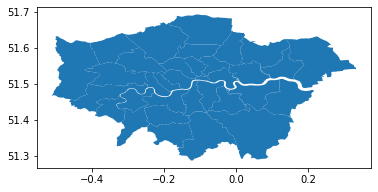

In [25]:
## Making a filtered geo_df of just the places with 'E09' in their string
## rathter than using str.contains, I'll use == instead
lond_districts = locAuth_map_df[locAuth_map_df.lad17cd.str[:3]=='E09']

## PLotting the london districts just to see how it looks
_ = lond_districts.plot()

In [26]:
## checking the new london districts df

lond_districts.head()

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
53,298,E09000005,Brent,None,519615,186468,-0.275680,51.5644,0.005603,0.456380,"POLYGON ((-0.26875 51.60087, -0.26136 51.59467..."
98,318,E09000025,Newham,None,540721,183327,0.027369,51.5313,0.004689,0.402297,"POLYGON ((0.05408 51.55984, 0.05471 51.55909, ..."
101,319,E09000026,Redbridge,None,543512,189478,0.070085,51.5859,0.007315,0.550043,"POLYGON ((0.03113 51.62274, 0.03582 51.61882, ..."
103,325,E09000032,Wandsworth,None,525152,174137,-0.200210,51.4524,0.004431,0.456191,"POLYGON ((-0.12797 51.48498, -0.12910 51.48254..."
106,310,E09000017,Hillingdon,None,508166,183120,-0.441820,51.5366,0.014998,0.717381,"POLYGON ((-0.49574 51.63154, -0.49514 51.63105..."


In [28]:
# Make a polygon to border the whole of London
## make a temp dataframe
_ = lond_districts
## make an extra column 'city_name' on which to dissolve on, making them all the same value, 'London'
_.loc[:,'city_name'] = 'London'
# ## make the polygon with dissolve, using city_name
whole_london_poly = _.dissolve(by='city_name')
## Seems like a bit of a bizzare method, but it works, I think

/home/james/anaconda3/envs/SDG_11.2.1/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


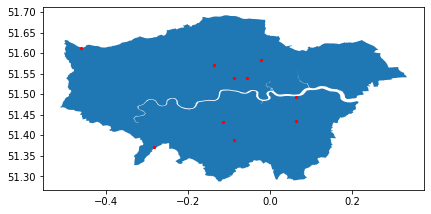

In [29]:
## plot the whole_london_poly polygon 
## with the selected stops laid over it 
fig, ax = plt.subplots()
_ =  whole_london_poly.plot(ax=ax)
_ = some_stops_in_LND.plot(ax=ax, color='red', markersize=5)
plt.tight_layout()

## great, this works!

In [30]:
## Although these selected stops are all within London and therefore within that polygon
## but using "within" or "contains" gives all false
any(some_stops_in_LND.within(whole_london_poly))
any(whole_london_poly.contains(some_stops_in_LND))
## but actually all of these stops are within the london polygon

False

In [31]:
#  checking if the CRS is the same in each DF. 
whole_london_poly.crs == some_stops_in_LND.crs 
# the crs is the same

True

In [32]:
#  Checking the CRS of Stops
some_stops_in_LND.crs

{'init': 'epsg:4326'}

In [33]:
#  Checking the CRS of London_lads
whole_london_poly.crs

{'init': 'epsg:4326'}

In [34]:
# I have tried a few different CRS's but as an example I am changing the CRS to 27700
## However this only seems to make things worse and muliplies all the coordinates in the whole_london_poly
## by 1000, but doesn't do the same 

# changing the crs in some_stops_in_LND 
new_crs_some_stops_in_LND = some_stops_in_LND
new_crs_some_stops_in_LND.to_crs(epsg=27700)

# London polygon
new_crs_whole_london_poly = whole_london_poly
new_crs_whole_london_poly.to_crs(epsg=27700)


,geometry,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths
city_name,,,,,,,,,,,
London,"MULTIPOLYGON (((516664.571 173281.384, 516396....",298,E09000005,Brent,NaN,519615,186468,-0.27568,51.5644,0.005603,0.45638


In [35]:
any(new_crs_some_stops_in_LND.within(new_crs_whole_london_poly))

## Even though they have both been converted to the same CRS they are still not within one another. 

False

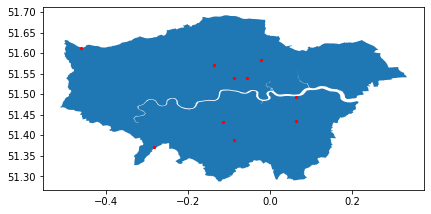

In [37]:
## plot the new_crs_whole_london_poly polygon 
fig, ax = plt.subplots()
_ =  new_crs_whole_london_poly.plot(ax=ax)
_ = new_crs_some_stops_in_LND.plot(ax=ax, color='red', markersize=5)
plt.tight_layout()

## although the stops are still plotted within the polygon